In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from scipy import stats

from scipy import stats, integrate
import seaborn as sns
from seaborn_qqplot import pplot





/Users/nlong/.pyenv/versions/3.7.7-metamodel/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# with plt.rc_context(dict(sns.axes_style("whitegrid"))):
#     fig = plt.figure(figsize=(6, 6), dpi=100)
#     sns.regplot(
#         x='y',
#         y='residuals',
#         data=df,
#         ci=None,
#         scatter_kws={"s": 50, "alpha": 1}
#     )
#     plt.tight_layout()

# setup the seaborn parameters
sns.set(color_codes=True)
config = sns.axes_style("whitegrid")
config['figure.figsize'] = (20,10)
config['xtick.labelsize'] = 18
config['ytick.labelsize'] = 18
config['axes.labelsize'] = 20

In [3]:
response_var = 'HeatingElectricity'
# response_var = 'CoolingElectricity'
# response_var = 'DistrictCoolingChilledWaterEnergy'
# response_var = 'DistrictHeatingHotWaterEnergy'
# response_var = 'ETSCoolingOutletTemperature'
# response_var = 'ETSHeatingOutletTemperature'
modeled_var = f'Modeled RF {response_var}'


df2 = pd.read_csv(f'output/smoff_sweep_v2_0.15/ValidationData/images/residual_ts_{response_var}_RF.csv')
# convert to Watts
df2[response_var] = df2[response_var] / 277777.77
df2[modeled_var] = df2[modeled_var] / 277777.77

df2['residuals'] = df2[response_var] - df2[modeled_var]  # y - yhat
# group weekdays/weekends
condlist = [df2.DayofWeek.between(1,5), df2.DayofWeek.isin([0,6])]
choices = ['Weekday', 'Weekend']
df2['DayType'] = np.select(condlist, choices)
# show random sample of data
# df2.sample(8).sort_index()
df2[['DayofWeek', 'DayType', response_var, modeled_var]].sample(8).sort_index()


,DayofWeek,DayType,HeatingElectricity,Modeled RF HeatingElectricity
1145,5,Weekday,0.000000,8.633287
1398,2,Weekday,35.560621,24.246953
2131,4,Weekday,0.000000,11.897390
2512,6,Weekend,0.000000,0.000000
2568,2,Weekday,0.000000,0.000000
4051,0,Weekend,0.000000,0.000000
4070,1,Weekday,0.000000,0.000000
6347,5,Weekday,0.000000,0.000000


In [4]:
# calculate the max and get the date of the max

maxes = df2[[response_var, modeled_var]].idxmax()
# mins = df2[[response_var, modeled_var]].idxmin()
sums = df2.sum()

actual_max_id = maxes[response_var]
# actual_min_id = mins[response_var]
actual_max = df2.at[actual_max_id, response_var]
actual_datetime = df2.at[actual_max_id, 'DateTime']

modeled_max_id = maxes[modeled_var]
modeled_max = df2.at[modeled_max_id, modeled_var]
modeled_datetime = df2.at[actual_max_id, 'DateTime']

print(response_var)
print(f"actual datetime: {actual_datetime}; modeled datetime {modeled_datetime}")
print(f"actual max: {actual_max}; modeled max {modeled_max}; %diff: {(modeled_max-actual_max)/actual_max*100}%")
print(f"actual sum: {sums[response_var]}; modeled sum {sums[modeled_var]}; %diff: {(sums[modeled_var]-sums[response_var])/sums[response_var]*100}%")



HeatingElectricity
actual datetime: 2006-12-18 05:00:00; modeled datetime 2006-12-18 05:00:00
actual max: 92.4724825892295; modeled max 103.70480690373459; %diff: 12.146666770481351%
actual sum: 15272.77685395775; modeled sum 22715.4403972284; %diff: 48.73156737926134%


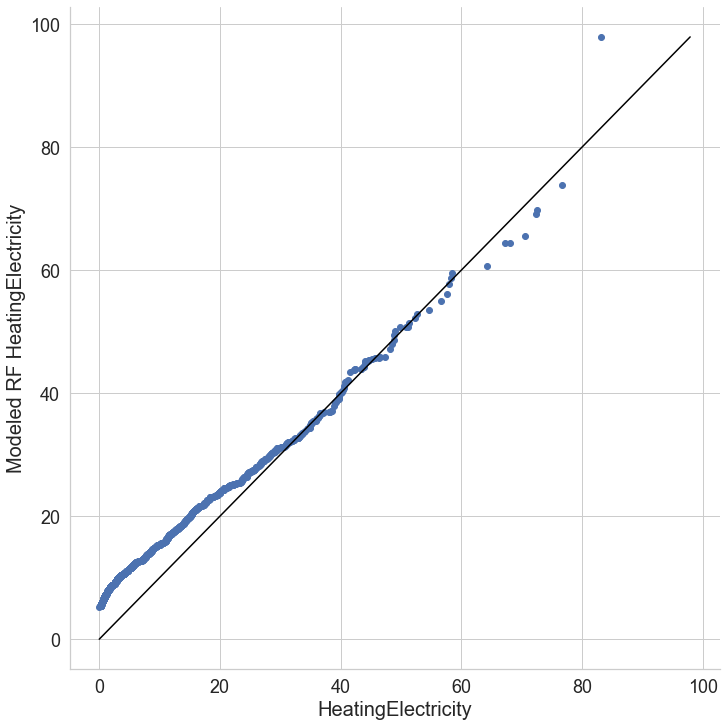

In [5]:
# plot the yy of the data
with plt.rc_context(config):
    ax = pplot(df2, x=response_var, y=modeled_var, kind='qq', height=10, aspect=1, display_kws={"identity":True})
    ax.savefig(f"{response_var}_qq.png")

HeatingElectricity


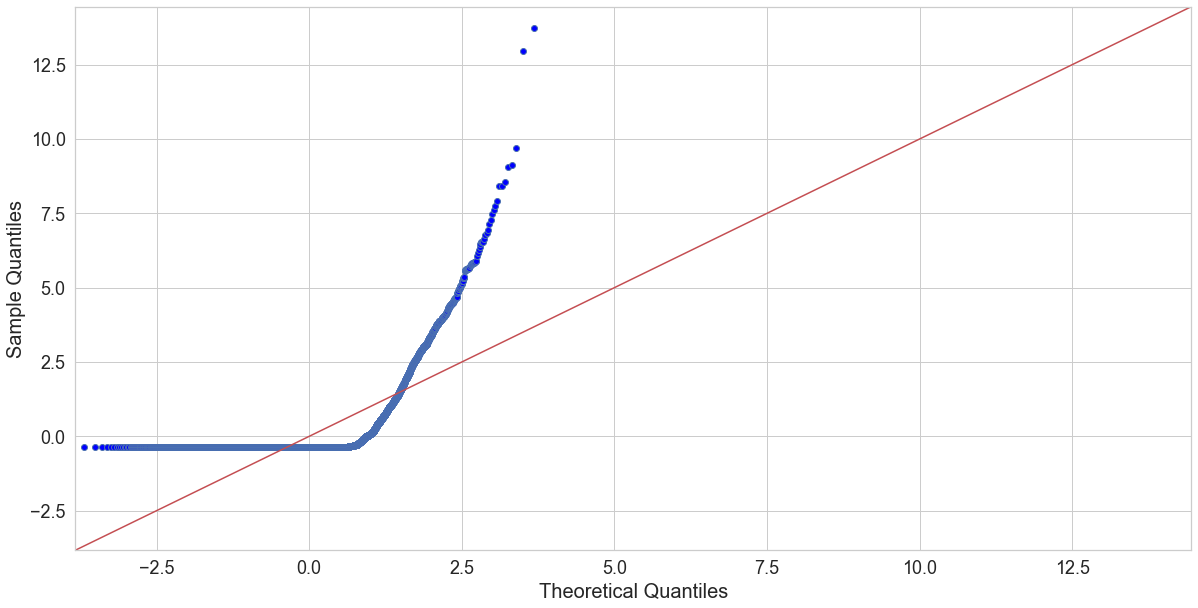

In [19]:
# qq of the data
import statsmodels.api as sm
print(response_var)
with plt.rc_context(config):
#     sm.qqplot(df2[modeled_var], line="45")
    sm.qqplot(df2[modeled_var], fit=True, line="45")
#     sm.qqplot(df2['residuals'], fit=True, line="45")

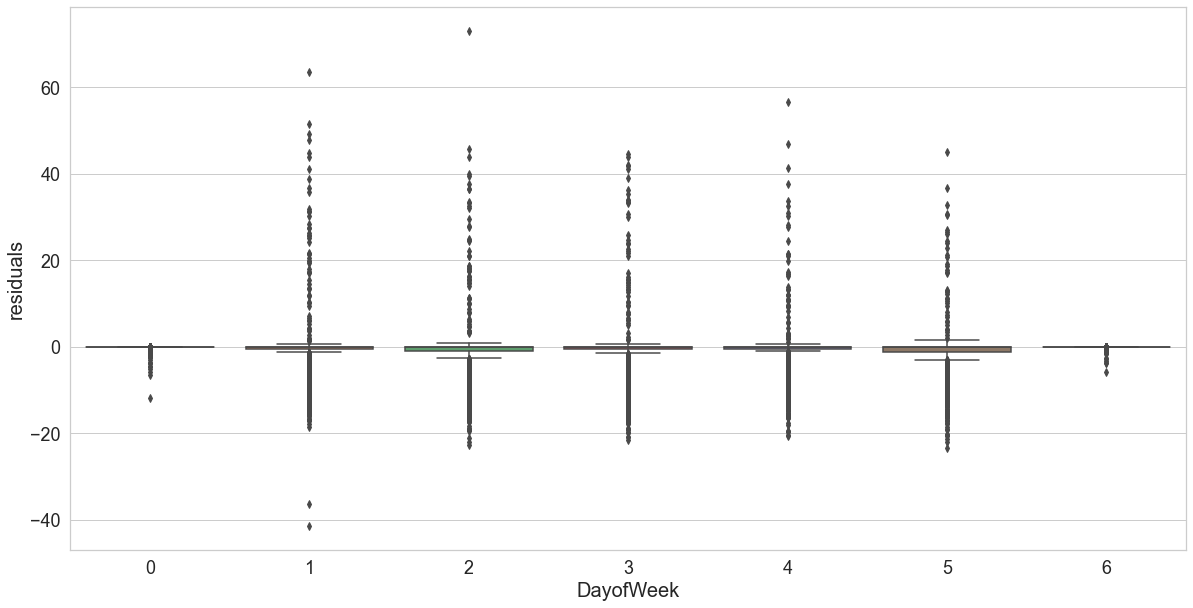

In [154]:
with plt.rc_context(config):
    # g = sns.catplot(x="DayofWeek", y="residuals", col="Month", data=df2)
    g = sns.boxplot(x="DayofWeek", y="residuals", data=df2).get_figure()
    plt.legend([],[], frameon=False)
    plt.savefig(f'{response_var}_residuals_7days.png')

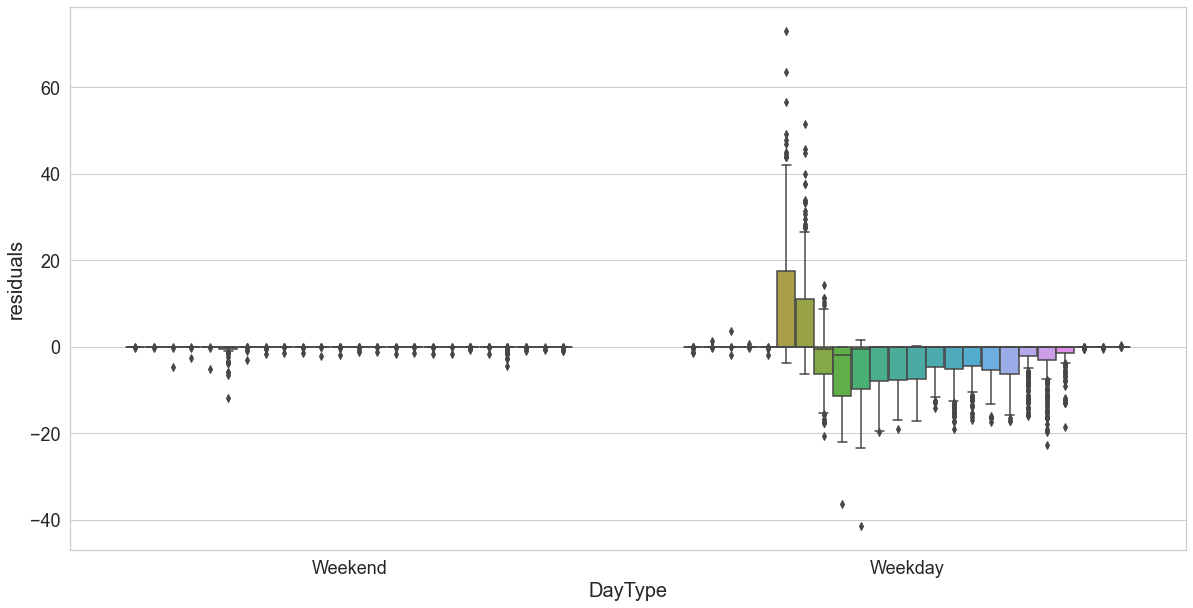

In [155]:
with plt.rc_context(config):
    g = sns.boxplot(x="DayType", y="residuals", hue="Hour", data=df2)
    plt.legend([],[], frameon=False)
    plt.savefig(f'{response_var}_residuals_2daytypes.png')

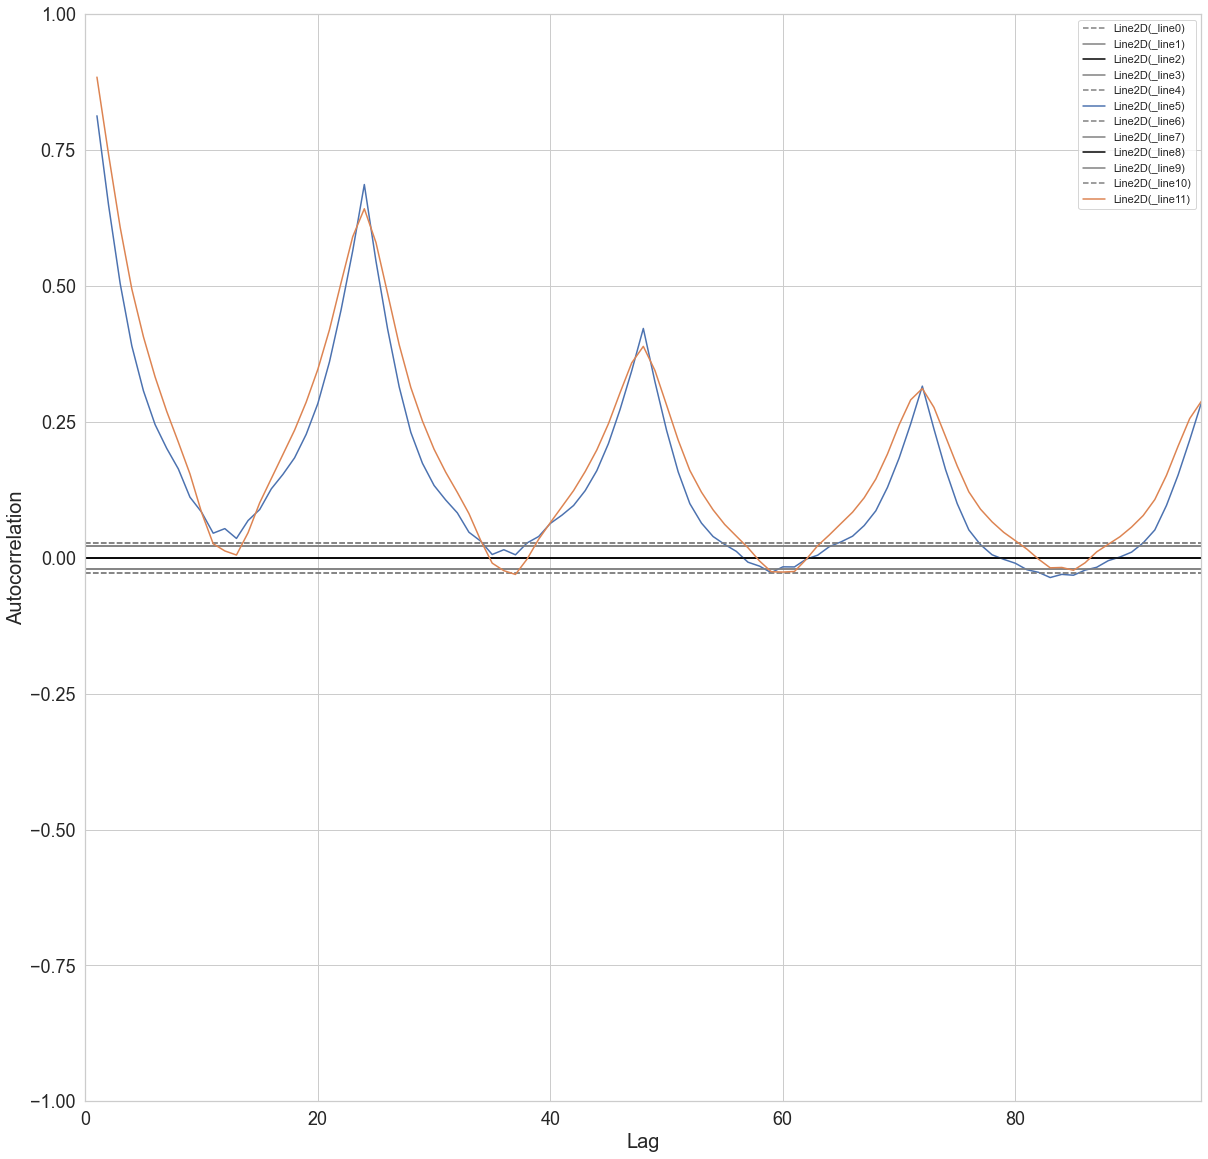

In [139]:
with plt.rc_context(config):
    ax = pd.plotting.autocorrelation_plot(df2[response_var]) 
    ax = pd.plotting.autocorrelation_plot(df2[modeled_var]) 
    ax.set_xlim([0, 96])
    ax.legend(ax.get_lines())
    plt.savefig(f'{response_var}_acf.png')

HeatingElectricity


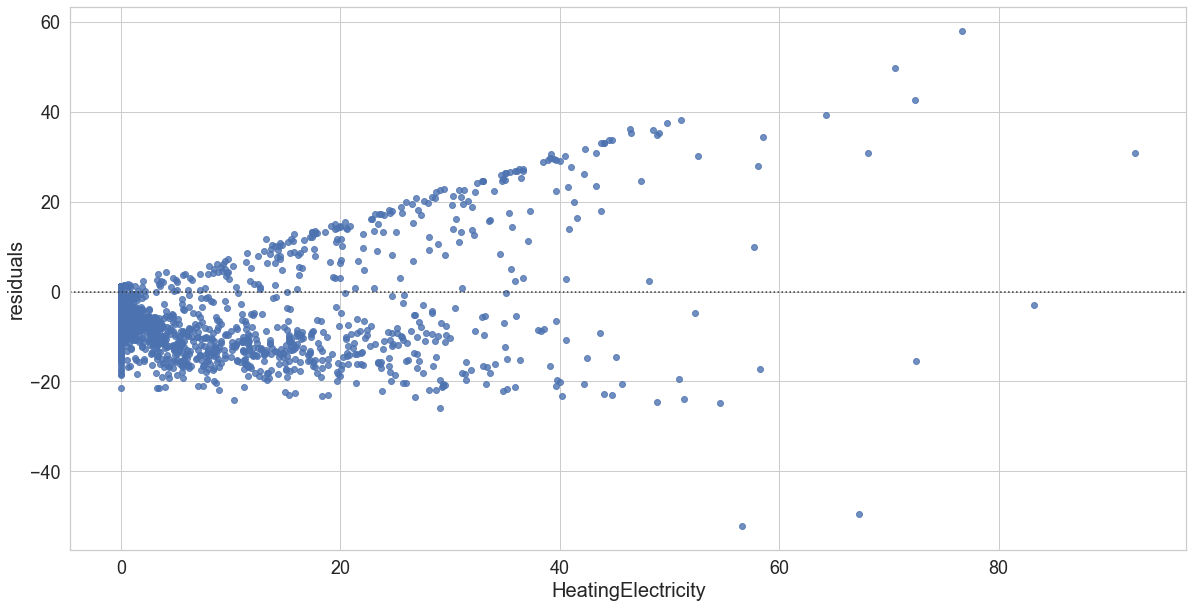

In [28]:
with plt.rc_context(config):
    sns.residplot(x=response_var, y='residuals', data=df2)

In [14]:
# melt df
df2_melted = pd.melt(df2[['DateTime', 'residuals']],
                   id_vars='DateTime',
                   var_name='Variable',
                   value_name='Value')
df2_melted

,DateTime,Variable,Value
0,2006-01-01 01:00:00,residuals,0.000000
1,2006-01-01 02:00:00,residuals,-0.060350
2,2006-01-01 03:00:00,residuals,-0.060350
3,2006-01-01 04:00:00,residuals,0.000000
4,2006-01-01 05:00:00,residuals,-0.526514
...,...,...,...
8755,2006-12-31 20:00:00,residuals,0.000000
8756,2006-12-31 21:00:00,residuals,0.000000
8757,2006-12-31 22:00:00,residuals,0.000000
8758,2006-12-31 23:00:00,residuals,0.000000


In [18]:
with plt.rc_context(config):
    ax = sns.lineplot(x='DateTime', y='residuals', data=df2, ci=None )
#     ax = sns.lineplot(data=df2_melted, x='DateTime', y='Value', hue='Variable')

#     ax.set(xlabel='', ylabel='Temperature (deg C)')
    ax.set(xlabel='', ylabel='Residual Power (W)')

    fig = ax.get_figure()
    # Put the labels at an angle since they tend to be too long
    fig.autofmt_xdate()
#     fig


Error in callback <function flush_figures at 0x115b90e60> (for post_execute):


KeyboardInterrupt: 